# **Interpreting Transformers Models**

## À propos

- **Auteur** : Mohammed Ali EL ADLOUNI et Angelo Lamure-Fontanin
- **Master** : Master M2 MALIA
- **Date** : 09/02/2025  


Dans ce projet, nous allons apprendre à interpréter BERT en utilisant un modèle finetuné sur un jeu de données Questions/ Réponses. BERT est une technique d’apprentissage automatique basée sur les transformeurs, utilisée pour l'entraînement préalable en traitement du langage naturel, développée par Google. On va utiliser le package Captum pour interpréter les résultats obtenus part notre modèle finetuné.

In [ ]:
# install required python packages
!pip install seaborn
!pip install pandas
!pip install matplotlib
!pip install transformers
!pip install captum
#mecab
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.996.3

#neologd
# !git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
# !echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

!pip install transformers
!pip install fugashi==1.1.0 ipadic==1.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
!pip install captum


In [ ]:
# import required python libraries
import numpy as np # multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import pandas as pd # data manipulation and analysis
import seaborn as sns # statistical data visualization
import matplotlib.pyplot as plt # object-oriented API for embedding plots

import torch # data structures for multi-dimensional tensors and defines mathematical operations over these tensors
import torch.nn as nn # basic building blocks for graphs
import json

# from transformers import pipeline
from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig # library for transformer models
from captum.attr import visualization as viz # captum visualization tool for matplotlib figure, it visualizes attribution for a given image by normalizing attribution values of the desired sign
from captum.attr import LayerConductance, LayerIntegratedGradients # computes conductance with respect to the given layer and provides integrated gradients augmenting accuracy metrics, model debugging and feature or rule extraction.


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


## Commented parts suggest how to use another pretrained model from hugging face. The model is a BERT-large-uncased model, pretrained on a corpus of messages from Twitter about COVID-19.

First, we fine-tune BERT model on SQUAD dataset. In this case, the fine-tuning is done on a **bert-base-uncased** pre-trained model.

After we pretrain the model, we can load the tokenizer and pre-trained BERT model using respectively the commands **BertForQuestionAnswering** and **BertTokenizer**.

In [ ]:
# replace <bert-case-uncased> with the path of the saved model
# https://huggingface.co/bert-base-uncased
model_path = 'bert-base-uncased'

model_path = 'digitalepidemiologylab/covid-twitter-bert-v2'

model_path = 'bert-large-uncased-whole-word-masking-finetuned-squad'

# model_path = "deepset/bert-base-cased-squad2"

# pipe = pipeline(task='fill-mask', model='digitalepidemiologylab/covid-twitter-bert-v2')
# out = pipe(f"In places with a lot of people, it's a good idea to wear a {pipe.tokenizer.mask_token}")
# print(json.dumps(out, indent=4))
# [
#     {
#         "sequence": "[CLS] in places with a lot of people, it's a good idea to wear a mask [SEP]",
#         "score": 0.9998226761817932,
#         "token": 7308,
#         "token_str": "mask"
#     },
#     ...
# ]


# load model
model = BertForQuestionAnswering.from_pretrained(model_path)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask, )
    return output.start_logits, output.end_logits

In [ ]:
def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values

In [ ]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [ ]:
def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]

    # construct reference token ids
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
        [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids

def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=token_type_ids, position_ids=position_ids)

    return input_embeddings, ref_input_embeddings

We now define a question - context (or text) pair as input for our BERT model and interpret what the model was focusing on when predicting an answer to the question from given input context.

In [ ]:
question, text = "Why should people wear masks?", "Masks are a key measure to suppress transmission and save lives."
ground_truth = 'key measure to suppress transmission and save lives.'


In [ ]:
question = "How does a transformer model process text?"
text = "A transformer model processes text using self-attention mechanisms, which allow it to capture relationships between words regardless of their position in a sentence."
ground_truth = "self-attention mechanisms"


We then embed the question, the input text and generate corresponding baselines/references. We use the **construct_whole_bert_embeddings** function  defined above for embedding the word, the **construct_input_ref_pos_id_pair** function for embedding the position, and the **construct_input_ref_token_type_pair** for embedding the token.

In [ ]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

We state our ground truth for prediction's start and end positions.

In [ ]:

ground_truth_tokens = tokenizer.encode(ground_truth, add_special_tokens=False)
ground_truth_end_ind = indices.index(ground_truth_tokens[-1])
ground_truth_start_ind = ground_truth_end_ind - len(ground_truth_tokens) + 1

To obtain our prediction we use the input, the token type, the position id and a default attention mask previously computed.

In [ ]:
start_scores, end_scores = predict(input_ids, \
                                   token_type_ids=token_type_ids, \
                                   position_ids=position_ids, \
                                   attention_mask=attention_mask)


print('Question: ', question)
print('Predicted Answer: ', ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))

Question:  How does a transformer model process text?
Predicted Answer:  using self - attention mechanisms


In [ ]:
print(all_tokens)
print(start_scores)
print(end_scores)
print(torch.argmax(start_scores))
print(torch.argmax(end_scores))
print(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1])

['[CLS]', 'how', 'does', 'a', 'transform', '##er', 'model', 'process', 'text', '?', '[SEP]', 'a', 'transform', '##er', 'model', 'processes', 'text', 'using', 'self', '-', 'attention', 'mechanisms', ',', 'which', 'allow', 'it', 'to', 'capture', 'relationships', 'between', 'words', 'regardless', 'of', 'their', 'position', 'in', 'a', 'sentence', '.', '[SEP]']
tensor([[-6.0561, -7.2892, -7.6947, -7.2445, -6.4842, -8.4624, -8.2223, -7.1403,
         -8.2182, -8.8409, -6.0559,  0.7330, -2.1084, -6.2360, -3.5203,  0.1577,
         -0.8625,  6.5314,  6.1142, -3.0589, -1.1005, -1.5092, -5.0484, -2.7635,
         -0.7227, -1.4061, -1.3512, -0.6149, -2.0153, -5.0059, -3.7264, -4.0722,
         -7.4750, -6.3680, -4.5466, -6.8729, -6.3824, -3.8506, -6.0561, -6.0559]],
       device='cuda:0', grad_fn=<CloneBackward0>)
tensor([[-0.6794, -7.1310, -7.0682, -7.0543, -7.2088, -6.0222, -5.9562, -7.0509,
         -6.9143, -7.2499, -0.6798, -5.8843, -5.6642, -3.8318, -3.9925, -4.1217,
         -3.7296, -2.1



```
# This is formatted as code
```

There are two different ways of computing the attributions for embedding layers. One option is to use **LayerIntegratedGradients** and compute the attributions with respect to BertEmbedding. The second option is to use **LayerIntegratedGradients** for **each word_embeddings**, **token_type_embeddings** and **position_embeddings** and compute the attributions w.r.t each embedding vector.

In [ ]:
lig = LayerIntegratedGradients(squad_pos_forward_func, model.bert.embeddings)

attributions_start, delta_start = lig.attribute(inputs=input_ids,
                                  baselines=ref_input_ids,
                                  additional_forward_args=(token_type_ids, position_ids, attention_mask, 0),
                                  return_convergence_delta=True)
attributions_end, delta_end = lig.attribute(inputs=input_ids, baselines=ref_input_ids,
                                additional_forward_args=(token_type_ids, position_ids, attention_mask, 1),
                                return_convergence_delta=True)


We then create an helper function to summarize attributions - **summarize_attributions** for each word token in the sequence. bold text

In [ ]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [ ]:
attributions_start_sum = summarize_attributions(attributions_start)
attributions_end_sum = summarize_attributions(attributions_end)

In [ ]:
# storing couple samples in an array for visualization purposes
start_position_vis = viz.VisualizationDataRecord(
                        attributions_start_sum,
                        torch.max(torch.softmax(start_scores[0], dim=0)),
                        torch.argmax(start_scores),
                        torch.argmax(start_scores),
                        str(ground_truth_start_ind),
                        attributions_start_sum.sum(),
                        all_tokens,
                        delta_start)

end_position_vis = viz.VisualizationDataRecord(
                        attributions_end_sum,
                        torch.max(torch.softmax(end_scores[0], dim=0)),
                        torch.argmax(end_scores),
                        torch.argmax(end_scores),
                        str(ground_truth_end_ind),
                        attributions_end_sum.sum(),
                        all_tokens,
                        delta_end)

print('\033[1m', 'Visualizations For Start Position', '\033[0m')
viz.visualize_text([start_position_vis])

print('\033[1m', 'Visualizations For End Position', '\033[0m')
viz.visualize_text([end_position_vis])

 Visualizations For Start Position 


 Visualizations For End Position 


In [ ]:
lig2 = LayerIntegratedGradients(squad_pos_forward_func, \
                                [model.bert.embeddings.word_embeddings, \
                                 model.bert.embeddings.token_type_embeddings, \
                                 model.bert.embeddings.position_embeddings])

attributions_start = lig2.attribute(inputs=(input_ids, token_type_ids, position_ids),
                                  baselines=(ref_input_ids, ref_token_type_ids, ref_position_ids),
                                  additional_forward_args=(attention_mask, 0))
attributions_end = lig2.attribute(inputs=(input_ids, token_type_ids, position_ids),
                                  baselines=(ref_input_ids, ref_token_type_ids, ref_position_ids),
                                  additional_forward_args=(attention_mask, 1))

attributions_start_word = summarize_attributions(attributions_start[0])
attributions_end_word = summarize_attributions(attributions_end[0])

attributions_start_token_type = summarize_attributions(attributions_start[1])
attributions_end_token_type = summarize_attributions(attributions_end[1])

attributions_start_position = summarize_attributions(attributions_start[2])
attributions_end_position = summarize_attributions(attributions_end[2])

/usr/local/lib/python3.11/dist-packages/captum/attr/_core/layer/layer_integrated_gradients.py:101: UserWarning: Multiple layers provided. Please ensure that each layer is**not** solely dependent on the outputs ofanother layer. Please refer to the documentation for moredetail.
  warnings.warn(


In [ ]:
def get_topk_attributed_tokens(attrs, k=5):
    values, indices = torch.topk(attrs, k)
    top_tokens = [all_tokens[idx] for idx in indices]
    return top_tokens, values, indices

In [ ]:
top_words_start, top_words_val_start, top_word_ind_start = get_topk_attributed_tokens(attributions_start_word)
top_words_end, top_words_val_end, top_words_ind_end = get_topk_attributed_tokens(attributions_end_word)

top_token_type_start, top_token_type_val_start, top_token_type_ind_start = get_topk_attributed_tokens(attributions_start_token_type)
top_token_type_end, top_token_type_val_end, top_token_type_ind_end = get_topk_attributed_tokens(attributions_end_token_type)

top_pos_start, top_pos_val_start, pos_ind_start = get_topk_attributed_tokens(attributions_start_position)
top_pos_end, top_pos_val_end, pos_ind_end = get_topk_attributed_tokens(attributions_end_position)

df_start = pd.DataFrame({'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words_start, top_word_ind_start, top_words_val_start)],
                   'Token Type(Index), Attribution': ["{} ({}), {}".format(ttype, pos, round(val.item(),2)) for ttype, pos, val in zip(top_token_type_start, top_token_type_ind_start, top_words_val_start)],
                   'Position(Index), Attribution': ["{} ({}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos_start, pos_ind_start, top_pos_val_start)]})
df_start.style.apply(['cell_ids: False'])

df_end = pd.DataFrame({'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words_end, top_words_ind_end, top_words_val_end)],
                   'Token Type(Index), Attribution': ["{} ({}), {}".format(ttype, pos, round(val.item(),2)) for ttype, pos, val in zip(top_token_type_end, top_token_type_ind_end, top_words_val_end)],
                   'Position(Index), Attribution': ["{} ({}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos_end, pos_ind_end, top_pos_val_end)]})
df_end.style.apply(['cell_ids: False'])

['{}({})'.format(token, str(i)) for i, token in enumerate(all_tokens)]

['[CLS](0)',
 'how(1)',
 'does(2)',
 'a(3)',
 'transform(4)',
 '##er(5)',
 'model(6)',
 'process(7)',
 'text(8)',
 '?(9)',
 '[SEP](10)',
 'a(11)',
 'transform(12)',
 '##er(13)',
 'model(14)',
 'processes(15)',
 'text(16)',
 'using(17)',
 'self(18)',
 '-(19)',
 'attention(20)',
 'mechanisms(21)',
 ',(22)',
 'which(23)',
 'allow(24)',
 'it(25)',
 'to(26)',
 'capture(27)',
 'relationships(28)',
 'between(29)',
 'words(30)',
 'regardless(31)',
 'of(32)',
 'their(33)',
 'position(34)',
 'in(35)',
 'a(36)',
 'sentence(37)',
 '.(38)',
 '[SEP](39)']

In [ ]:
# prompt: how to know type of df_start

print(type(df_start))


<class 'pandas.core.frame.DataFrame'>


In [ ]:
df_start

,"Word(Index), Attribution","Token Type(Index), Attribution","Position(Index), Attribution"
0,"self (18), 0.95","[SEP] (10), 0.95","self (18), 0.92"
1,"using (17), 0.2","[SEP] (39), 0.2","using (17), 0.21"
2,"which (23), 0.09","self (18), 0.09","a (3), 0.11"
3,"a (3), 0.08","- (19), 0.08","which (23), 0.08"
4,"allow (24), 0.07","which (23), 0.07","allow (24), 0.08"


In [ ]:
# prompt: print df_start in a latex aesthetic table so i can copy it in my latex code

print(df_start.to_latex(index=False))


print(df_end.to_latex(index=False))


\begin{tabular}{lll}
\toprule
Word(Index), Attribution & Token Type(Index), Attribution & Position(Index), Attribution \\
\midrule
self (18), 0.95 & [SEP] (10), 0.95 & self (18), 0.92 \\
using (17), 0.2 & [SEP] (39), 0.2 & using (17), 0.21 \\
which (23), 0.09 & self (18), 0.09 & a (3), 0.11 \\
a (3), 0.08 & - (19), 0.08 & which (23), 0.08 \\
allow (24), 0.07 & which (23), 0.07 & allow (24), 0.08 \\
\bottomrule
\end{tabular}

\begin{tabular}{lll}
\toprule
Word(Index), Attribution & Token Type(Index), Attribution & Position(Index), Attribution \\
\midrule
mechanisms (21), 0.82 & [SEP] (10), 0.82 & mechanisms (21), 0.91 \\
using (17), 0.37 & [SEP] (39), 0.37 & using (17), 0.27 \\
self (18), 0.33 & mechanisms (21), 0.33 & self (18), 0.19 \\
, (22), 0.17 & self (18), 0.17 & text (16), 0.08 \\
text (16), 0.12 & , (22), 0.12 & processes (15), 0.06 \\
\bottomrule
\end{tabular}



In [ ]:
df_end

,"Word(Index), Attribution","Token Type(Index), Attribution","Position(Index), Attribution"
0,"mechanisms (21), 0.82","[SEP] (10), 0.82","mechanisms (21), 0.91"
1,"using (17), 0.37","[SEP] (39), 0.37","using (17), 0.27"
2,"self (18), 0.33","mechanisms (21), 0.33","self (18), 0.19"
3,", (22), 0.17","self (18), 0.17","text (16), 0.08"
4,"text (16), 0.12",", (22), 0.12","processes (15), 0.06"


In [ ]:
def squad_pos_forward_func2(input_emb, attention_mask=None, position=0):
    pred = model(inputs_embeds=input_emb, attention_mask=attention_mask, )
    pred = pred[position]
    return pred.max(1).values

In [ ]:
layer_attrs_start = []
layer_attrs_end = []

# The token that we would like to examine separately.
token_to_explain = 21 # the index of the token that we would like to examine more thoroughly
layer_attrs_start_dist = []
layer_attrs_end_dist = []

input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                         token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)

for i in range(model.config.num_hidden_layers):
    lc = LayerConductance(squad_pos_forward_func2, model.bert.encoder.layer[i])
    layer_attributions_start = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(attention_mask, 0))
    layer_attributions_end = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(attention_mask, 1))
    layer_attrs_start.append(summarize_attributions(layer_attributions_start).cpu().detach().tolist())
    layer_attrs_end.append(summarize_attributions(layer_attributions_end).cpu().detach().tolist())

    # storing attributions of the token id that we would like to examine in more detail in token_to_explain
    layer_attrs_start_dist.append(layer_attributions_start[0,token_to_explain,:].cpu().detach().tolist())
    layer_attrs_end_dist.append(layer_attributions_end[0,token_to_explain,:].cpu().detach().tolist())

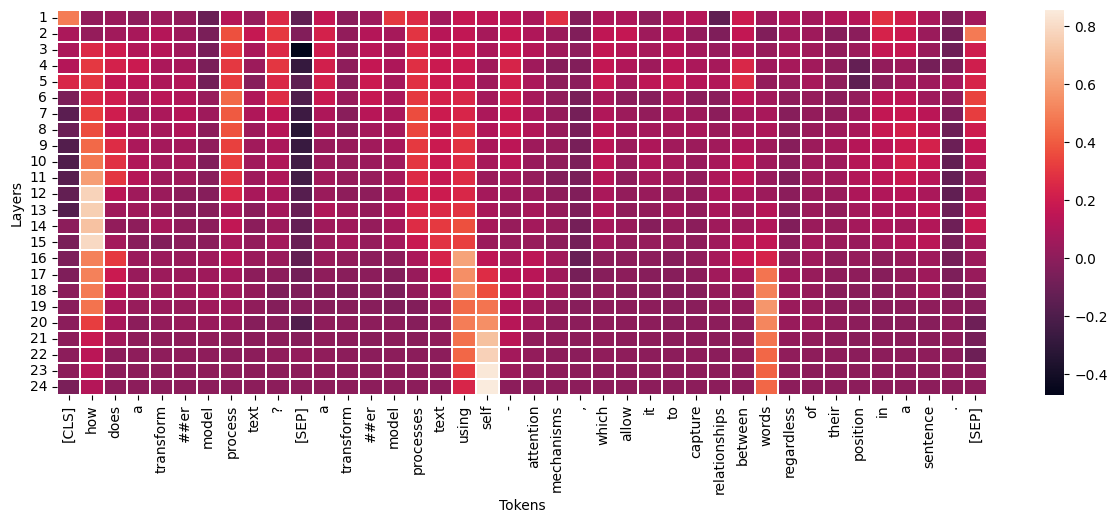

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(1,25))
ax = sns.heatmap(np.array(layer_attrs_start), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

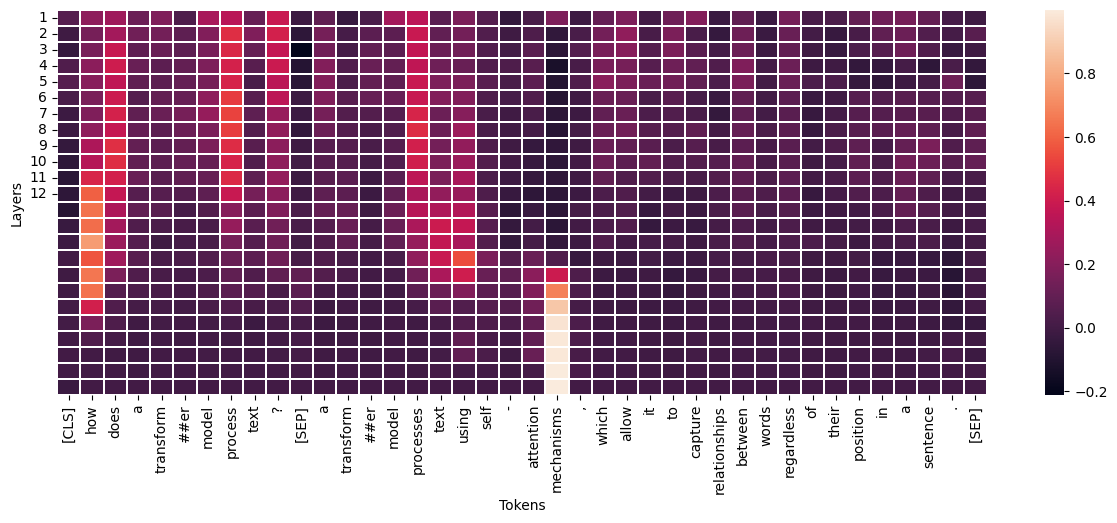

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs_end), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2) #, annot=True
plt.xlabel('Tokens')
plt.ylabel('Layers')

plt.show()

In [ ]:
print(len(layer_attrs_start_dist))

24


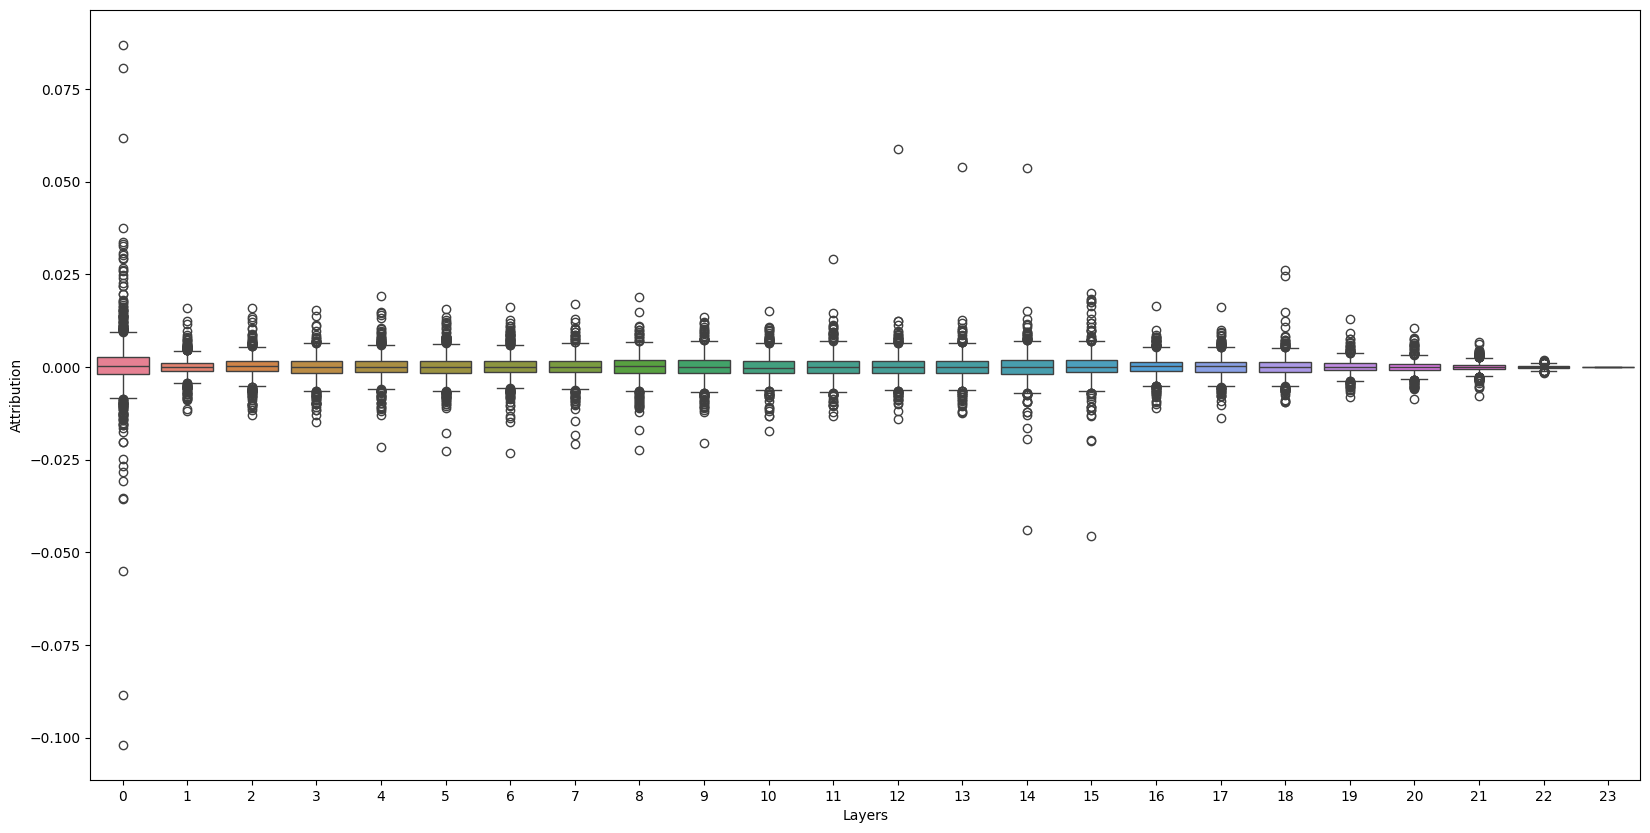

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_start_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

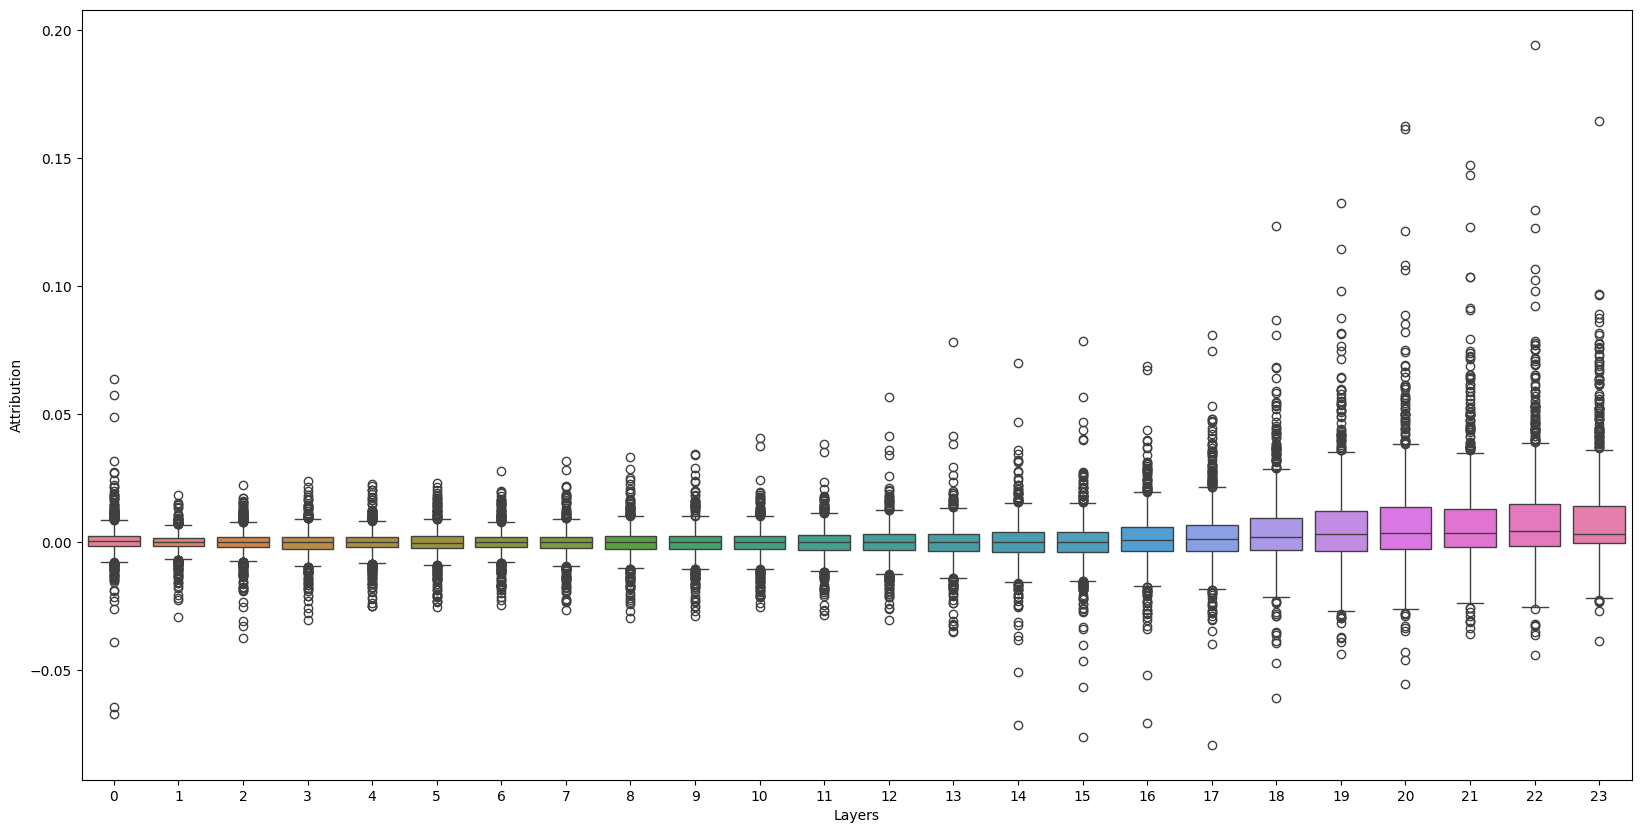

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_end_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

In [ ]:
def pdf_attr(attrs, bins=50):
    return np.histogram(attrs, bins=bins, density=True)[0]

In [ ]:
layer_attrs_end_pdf = map(lambda layer_attrs_end_dist: pdf_attr(layer_attrs_end_dist), layer_attrs_end_dist)
layer_attrs_end_pdf = np.array(list(layer_attrs_end_pdf))

# summing attribution along embedding diemension for each layer
# size: #layers
attr_sum = np.array(layer_attrs_end_dist).sum(-1)

# size: #layers
layer_attrs_end_pdf_norm = np.linalg.norm(layer_attrs_end_pdf, axis=-1, ord=1)

#size: #bins x #layers
layer_attrs_end_pdf = np.transpose(layer_attrs_end_pdf)

#size: #bins x #layers
layer_attrs_end_pdf = np.divide(layer_attrs_end_pdf, layer_attrs_end_pdf_norm, where=layer_attrs_end_pdf_norm!=0)

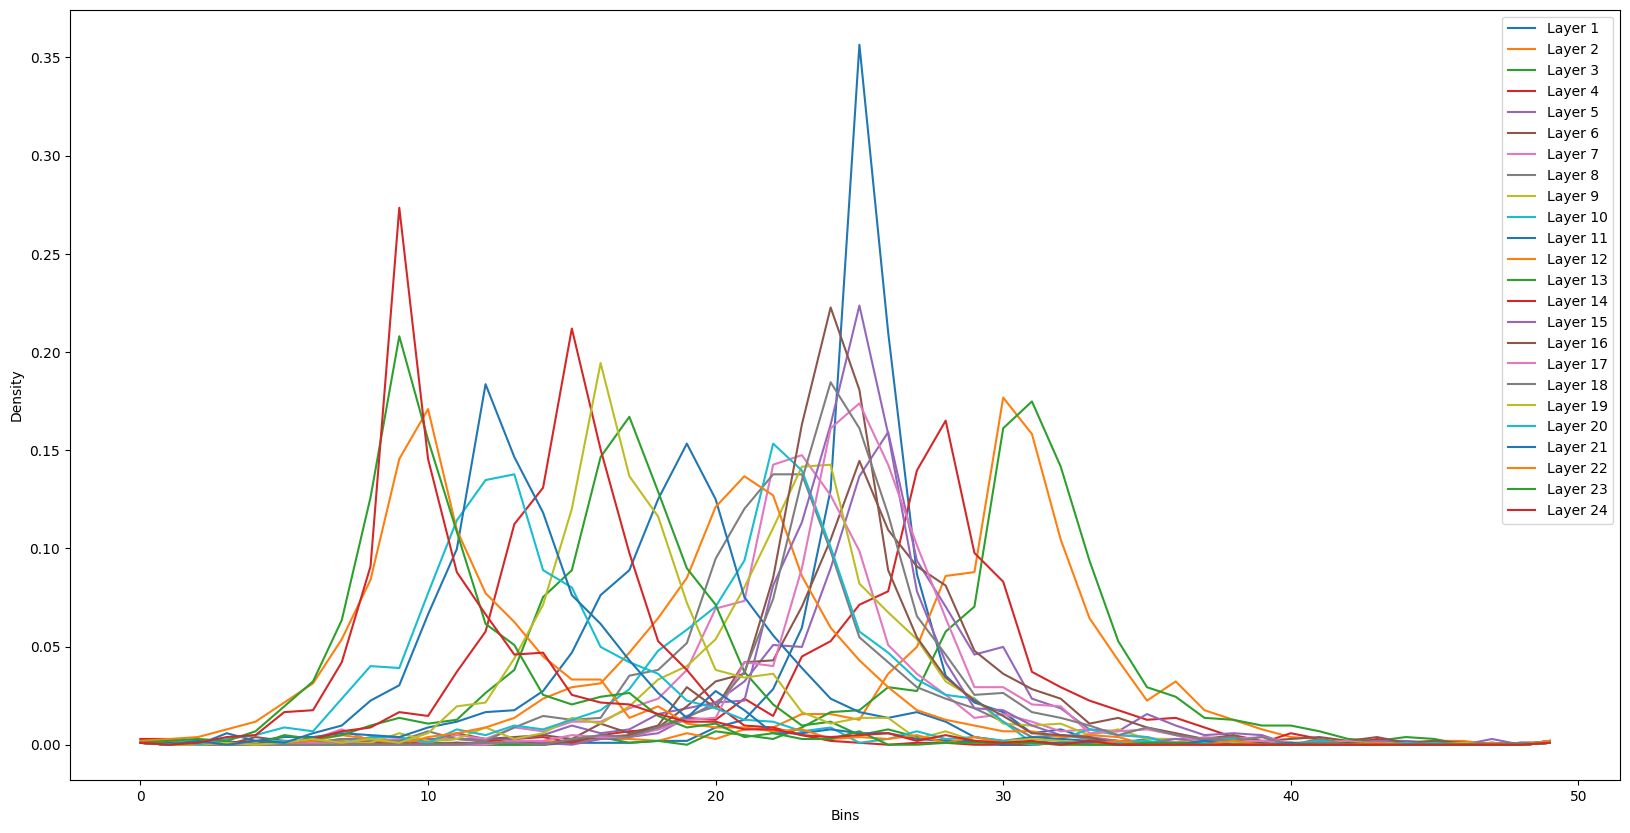

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(layer_attrs_end_pdf)
plt.xlabel('Bins')
plt.ylabel('Density')
plt.legend(['Layer '+ str(i) for i in range(1,25)])
plt.show()

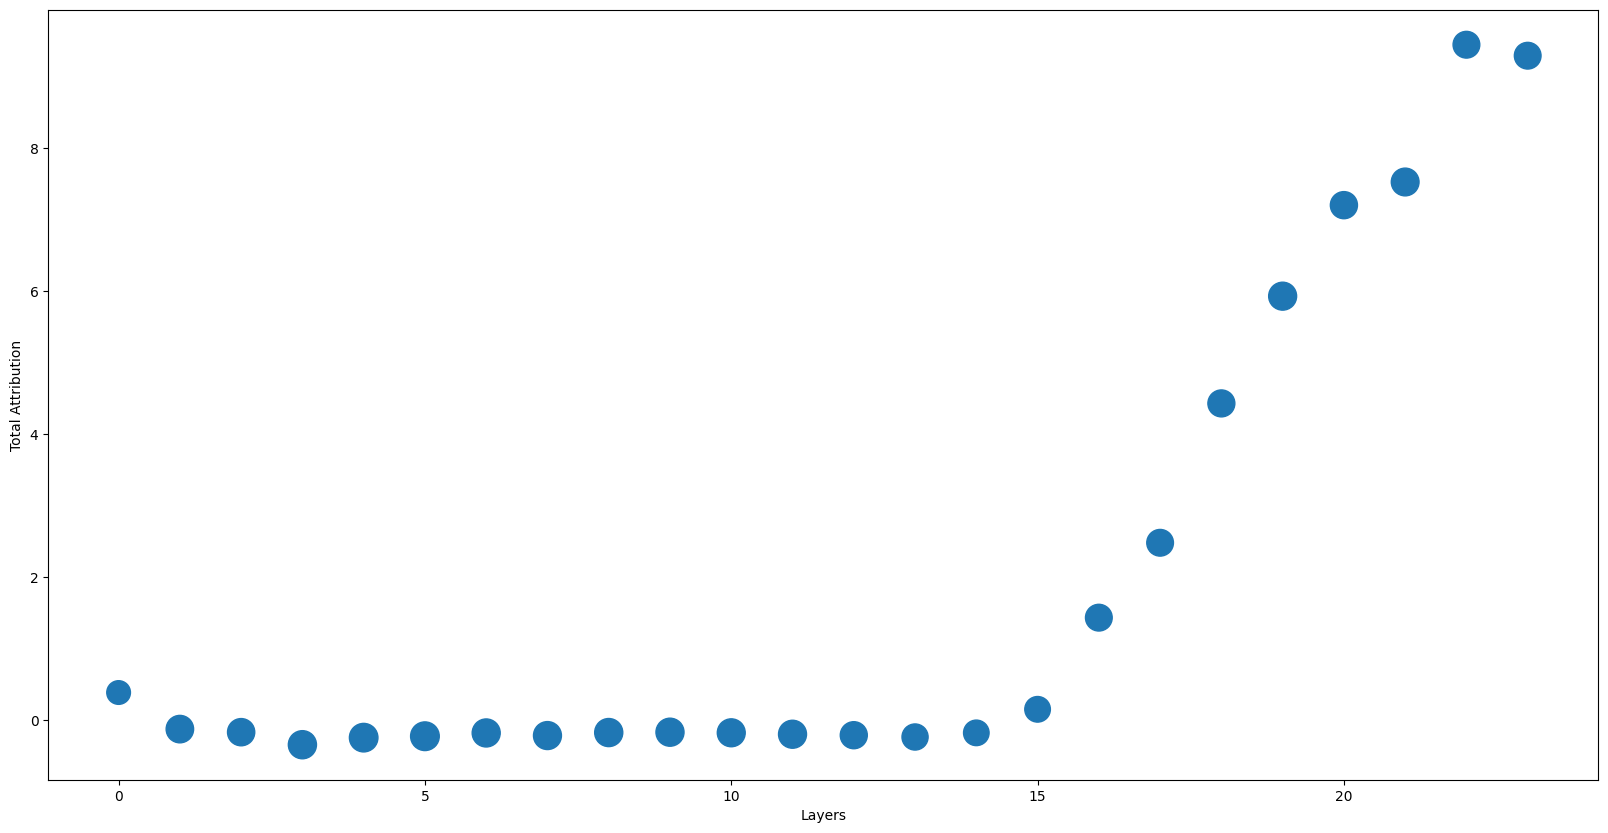

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

# replacing 0s with 1s. np.log(1) = 0 and np.log(0) = -inf
layer_attrs_end_pdf[layer_attrs_end_pdf == 0] = 1
layer_attrs_end_pdf_log = np.log2(layer_attrs_end_pdf)

# size: #layers
entropies= -(layer_attrs_end_pdf * layer_attrs_end_pdf_log).sum(0)

plt.scatter(np.arange(24), attr_sum, s=entropies * 100)
plt.xlabel('Layers')
plt.ylabel('Total Attribution')
plt.show()